In [85]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFT
from qiskit.circuit.library import ZGate
from qiskit.circuit.library import IntegerComparator
from clc_oracle import apply_clc
from controlled_u import apply_grover_diffusion_operator
from qiskit.primitives import Estimator
from qiskit.primitives import StatevectorSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_aer import Aer
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
# NEED TO CHANGE SO THAT WE CAN PASS IN GRAPH FROM MAIN NOTEBOOK
def generate_tsp_instance(num_cities):
    G = nx.erdos_renyi_graph(num_cities, 0.86)
    for e in G.edges():
        G.add_edge(e[0], e[1], weight=np.round(np.random.uniform(0,2 * np.pi),3))
    adj_mat = nx.adjacency_matrix(G)
    total = np.sum(adj_mat)
    for e in G.edges():
        G.add_edge(e[0], e[1], weight=np.round(adj_mat[e[0], e[1]]/total,5))
    return G

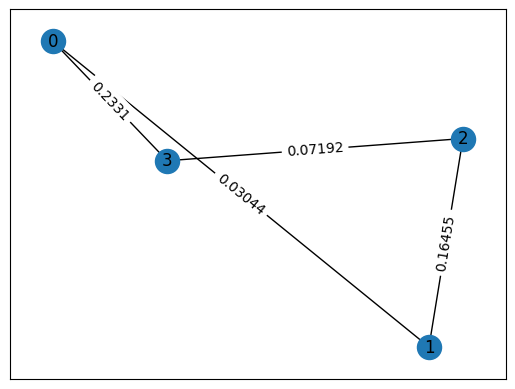

In [161]:
# Define TSP Instance
G = generate_tsp_instance(4)

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

In [162]:
m = 2
t = 3
N = 4
i = 0
Iopt = np.pi * np.sqrt(2**(m*N)) / 4
constants = {"m":m, "N":N, "t":t, "i":i, "Iopt":Iopt}

[0.99953674+0.0304353j  1.        +0.j         0.97295499+0.23099479j
 1.        +0.j        ]
[0.99953674+0.0304353j  0.98649217+0.16380843j 1.        +0.j
 1.        +0.j        ]
[1.        +0.j         0.98649217+0.16380843j 0.99741487+0.07185802j
 1.        +0.j        ]
[0.97295499+0.23099479j 1.        +0.j         0.99741487+0.07185802j
 1.        +0.j        ]
[0.99953674+0.0304353j  1.        +0.j         0.97295499+0.23099479j
 1.        +0.j        ]
[0.99953674+0.0304353j  0.98649217+0.16380843j 1.        +0.j
 1.        +0.j        ]
[1.        +0.j         0.98649217+0.16380843j 0.99741487+0.07185802j
 1.        +0.j        ]
[0.97295499+0.23099479j 1.        +0.j         0.99741487+0.07185802j
 1.        +0.j        ]


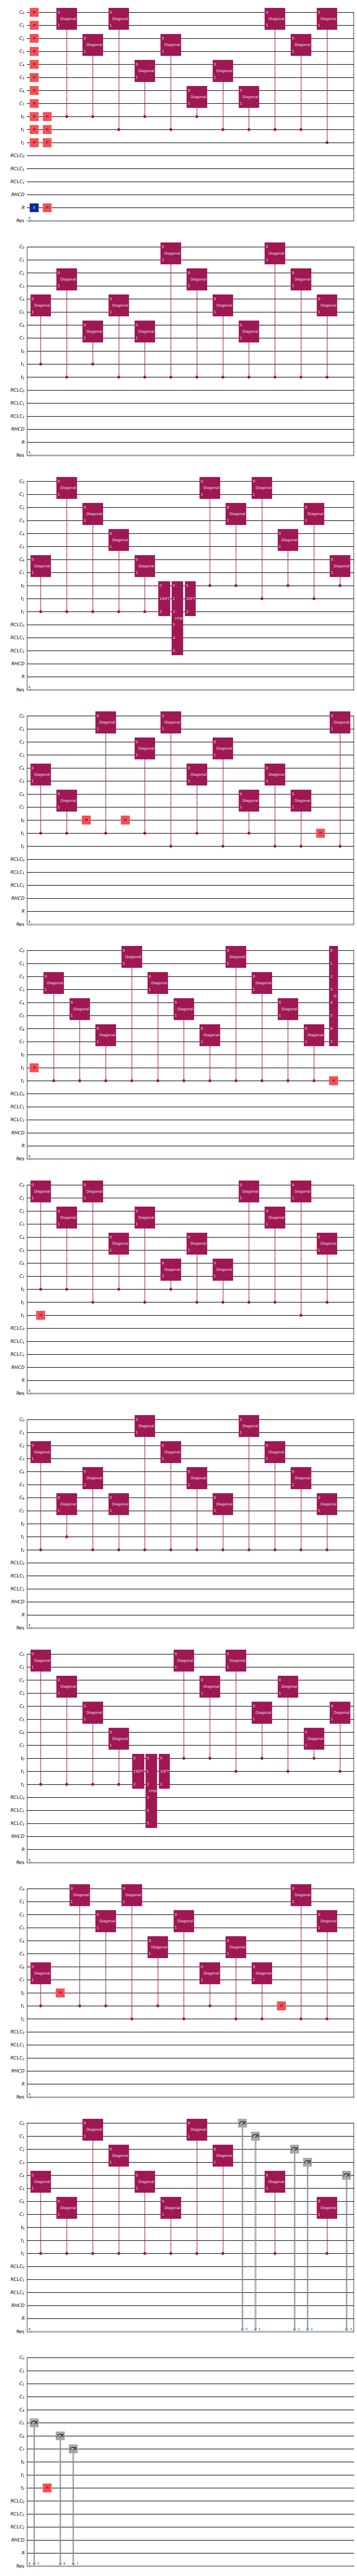

In [163]:
qr_C = QuantumRegister(m*N, 'C')
qr_t = QuantumRegister(t, 't')
qr_RCLC = QuantumRegister(t, 'RCLC')
qr_RHCD = QuantumRegister(1, 'RHCD')
qr_R = QuantumRegister(1, 'R')
cr_C = ClassicalRegister(m*N, 'Res')
registers = {"C":qr_C, "t":qr_t, "R":qr_R, "RCLC":qr_RCLC, "RHCD":qr_RHCD}

TSPcircuit = QuantumCircuit(qr_C, qr_t, qr_RCLC, qr_RHCD, qr_R, cr_C)

TSPcircuit.x(qr_R)
TSPcircuit.h(qr_R)

for qubit in range(m*N):
    TSPcircuit.h(qr_C[qubit])

for qubit in range(t):
    TSPcircuit.h(qr_t[qubit])

TSPcircuit = apply_clc(TSPcircuit, registers, constants, G)

TSPcircuit = apply_grover_diffusion_operator(TSPcircuit, registers, constants)

TSPcircuit = apply_clc(TSPcircuit, registers, constants, G)

TSPcircuit.measure(qr_C, cr_C)
TSPcircuit.draw(output='mpl')

In [164]:
sim = Aer.get_backend('qasm_simulator')
new_circuit = transpile(TSPcircuit, backend=sim)
job = sim.run(new_circuit) # Need to determine lower bound on suitable number of shots to take
result = job.result()
paths = result.get_counts()
print(paths)

{'01000100': 2, '01100001': 1, '10011100': 1, '10101100': 2, '10000100': 3, '00100001': 1, '11011101': 1, '10001011': 3, '01100010': 2, '00110111': 1, '01111111': 3, '00001010': 2, '01000010': 4, '11101100': 1, '11011010': 3, '11100100': 1, '10101001': 1, '10110001': 1, '00101001': 2, '10100110': 6, '11100111': 2, '01110101': 4, '01001101': 3, '01001001': 6, '01111000': 4, '00010010': 6, '11100000': 2, '01110000': 2, '11111010': 3, '01010011': 1, '00011001': 3, '00001000': 4, '01101101': 6, '10101101': 2, '00110101': 3, '00111000': 4, '01011100': 2, '00001100': 1, '01110111': 2, '00010001': 4, '01000101': 7, '00110000': 4, '11011011': 6, '11100010': 3, '11110101': 4, '10010100': 7, '00101010': 4, '01011011': 3, '01110110': 4, '00010011': 4, '11010011': 5, '11000000': 6, '00000100': 4, '01010001': 4, '10101110': 4, '11101011': 2, '01111110': 4, '11101010': 5, '00010100': 3, '00010000': 2, '01101000': 5, '11110100': 6, '11011100': 3, '11010111': 2, '10111110': 3, '10111000': 5, '01011000

### Processing Measurements

In [165]:
def bitstring_to_decimal_path(N, m, bit_path):
    """ 
    Convert bitstring path to decimal path
    """
    int_path = []
    for i in range(N):
        city = bit_path[i * m : (i + 1) * m]
        int_path.append(int(city,2))
    return int_path

def check_hamiltonian_cycle(bitstring, num_cities, adj_mat, adj_list):
    d = np.max([len(l) for l in adj_list])
    m = int(np.ceil(np.log(d)))
    decimal_path = bitstring_to_decimal_path(num_cities, m, bitstring)
    cost = 0
    curr_city = 0
    count = 0
    path = [0]
    while (count < num_cities):
        if (curr_city >= len(adj_list) or decimal_path[curr_city] >= len(adj_list[curr_city])):
            return False, path, cost, True
        next_city = adj_list[curr_city][decimal_path[curr_city]]
        cost += adj_mat[curr_city, next_city]
        path.append(next_city)
        curr_city = next_city 
        count += 1
    if (len(set(path)) == num_cities and path[0] == path[-1]):
        return True, path, cost, False
    else:
        return False, path, cost, False

In [166]:
adj_matrix = nx.adjacency_matrix(G) # Adjacency Matrix for TSP Instance
adj_lists = [[c for c in G[i]] for i in G.nodes()] # Adjacency List for TSP Instance
d = np.max([len(l) for l in adj_lists])

In [167]:
bitstring_to_counts = {k: v for k, v in sorted(paths.items(), key=lambda item: item[1], reverse=True)}
print("BITSTRING-TO-COUNTS DICT: " + str(bitstring_to_counts))
ham_cycles = []
skipped_cycles = []
min_cost = len(G) * 2 * np.pi
min_cycle = 0
for path in bitstring_to_counts:
    bitstring = path
    is_ham_cycle, path, cost, skipped = check_hamiltonian_cycle(bitstring, len(G), adj_matrix, adj_lists)
    if (skipped):
        skipped_cycles.append((bitstring, bitstring_to_counts[bitstring]))
    if (is_ham_cycle):
        if (cost < min_cost):
            min_cost = cost 
            min_cycle = (bitstring, path)
        ham_cycles.append((bitstring, path, cost))
print("HAMILTONIAN CYCLES: " + str(ham_cycles))
print('\n')
print("MINIMUM HAMILTONIAN CYCLE: " + str((min_cycle, min_cost, bitstring_to_counts[min_cycle[0]])))
print('\n')
print("SKIPPED CYCLES: " + str(skipped_cycles))

BITSTRING-TO-COUNTS DICT: {'01110011': 12, '11001011': 10, '00011000': 10, '10011010': 9, '10110011': 9, '01000001': 9, '00100111': 9, '00100110': 9, '11111100': 8, '11001111': 8, '10001111': 8, '00010111': 8, '10010010': 8, '01000101': 7, '10010100': 7, '01111010': 7, '01011001': 7, '10101011': 7, '10110010': 7, '11111011': 7, '10110000': 7, '01010110': 7, '00010101': 7, '00011010': 7, '00110110': 7, '00101011': 7, '10111011': 7, '10100110': 6, '01001001': 6, '00010010': 6, '01101101': 6, '11011011': 6, '11000000': 6, '11110100': 6, '11010110': 6, '00001110': 6, '01001011': 6, '11101000': 6, '10001110': 6, '01100011': 6, '01100110': 6, '11110110': 6, '10111101': 6, '01101100': 6, '01000011': 6, '00000110': 6, '00100100': 6, '10000001': 6, '01101110': 6, '00010110': 6, '11110000': 6, '01100000': 6, '00110010': 6, '00011110': 6, '01111001': 6, '11010010': 6, '01111011': 6, '11001100': 6, '11010011': 5, '11101010': 5, '01101000': 5, '10111000': 5, '11001000': 5, '10100011': 5, '11110011'

In [168]:
# NetworkX Solution
nx_tsp = nx.approximation.traveling_salesman_problem
nx_tsp(G)

[0, 3, 2, 1, 0]